In [1]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2021-12-07 16:46:39--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

100%[======================================>] 9,912,422   54.6MB/s   in 0.2s   

2021-12-07 16:46:39 (54.6 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2021-12-07 16:46:39--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 104.21.29.36, 172.67.171.76, 2606:4700:3034::6815:1d24, ...
Connecting to yann.lecun.com (yann.lecun.com)|104.21.29.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

100%[===============================

In [2]:
import struct
import gzip
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
# create dictionaries to store the data

In [3]:
train = dict()
test = dict()

In [4]:
def get_images(filename) :
    with gzip.GzipFile(Path('./', filename), 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        print(magic, size, rows, cols)
        images = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return images.reshape (size, rows, cols)

In [5]:
train['image'] = get_images('train-images-idx3-ubyte.gz')
test['image'] = get_images('t10k-images-idx3-ubyte.gz')
print(train['image'].shape, test['image'].shape)

2051 60000 28 28
2051 10000 28 28
(60000, 28, 28) (10000, 28, 28)


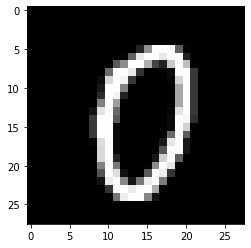

In [6]:
fig , ax = plt.subplots()
ax.imshow(train['image'][1000], cmap = 'gray')

In [8]:
def get_labels(filename) :
    with gzip.GzipFile(Path('./', filename), 'rb') as f:
        magic, num = struct.unpack(">II", f.read( 8 ))
        labels = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return labels

In [9]:
train['label'] = get_labels('train-labels-idx1-ubyte.gz')
test['label'] = get_labels('t10k-labels-idx1-ubyte.gz')
print(train['label'].shape, test['label'].shape)

(60000,) (10000,)


In [10]:
#check that labels are between expected values
np.unique(train['label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [11]:
def oneD_bias_img(image):
    #create a zero array and makes images 1D
    flat = np.zeros((image.shape[0], np.product(image.shape[1:])))
    for i in range(flat.shape[0]):
        flat[i] = image[i].flatten()
    #adds a column of 1's to prevent bias for i.i.d r.v.
    unbias_array = np.concatenate([flat, np.ones((flat.shape[0], 1))], axis=1)
    return unbias_array


def transform_images(x):
    x0 = np.zeros((x.shape[0], np.product(x.shape[1:])))
    
    for i in range(x0.shape[0]):
        x0[i] = x[i].flatten()
            
    return np.concatenate([x0, np.ones((x0.shape[0], 1))], axis=1)

    
def binary_response(labels, number):
    """takes the labels array and a number you would like the model to recognize
    it returns an array of 1 and -1 depending if the target value was found"""
    binary_col = np.zeros((labels.shape[0], 1))   
    for i in range(binary_col.shape[0]):
        
        if labels[i] == number:
            binary_col[i] = 1
        else:
            binary_col[i] = -1
    return binary_col

def beta(x, y):
    b = np.matmul(np.linalg.pinv(np.matmul(x.transpose(), x)), np.matmul(x.transpose(), y))
    return b

1.4581642942372024


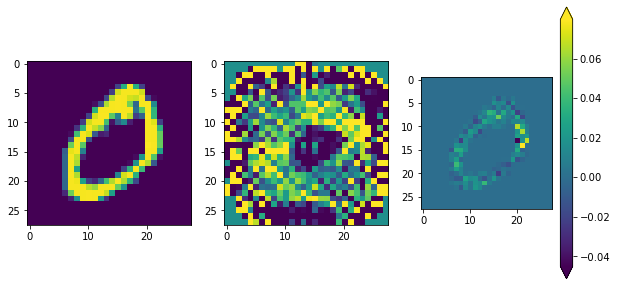

0.8895772185535102


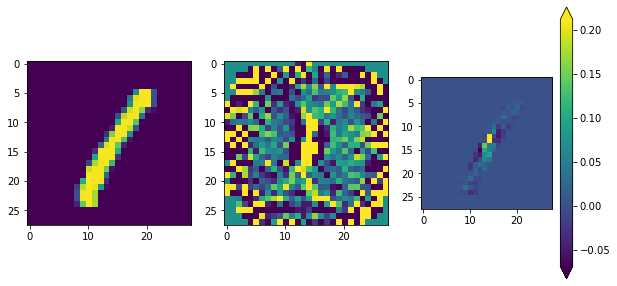

1.1316601772702501


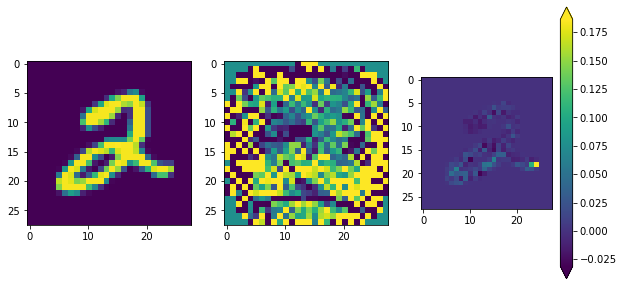

1.1931739925735805


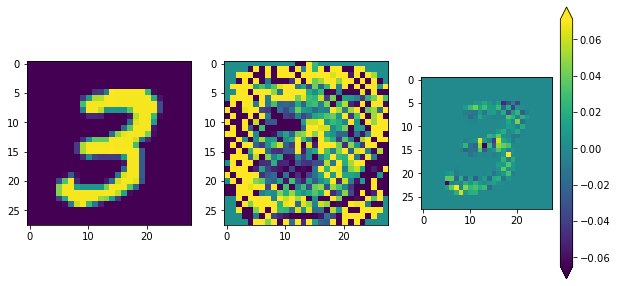

0.9527510315709807


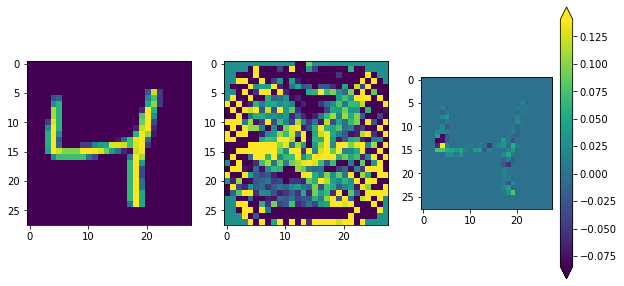

0.6451112257474347


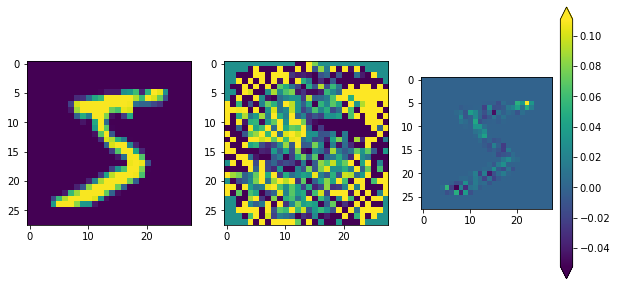

1.2376053260262436


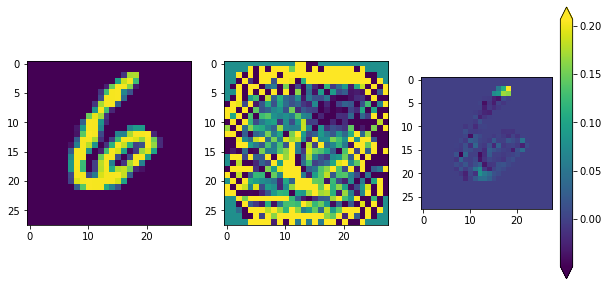

1.0098124077095416


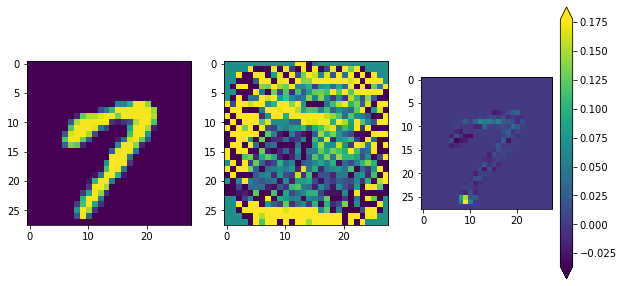

1.3443474366671526


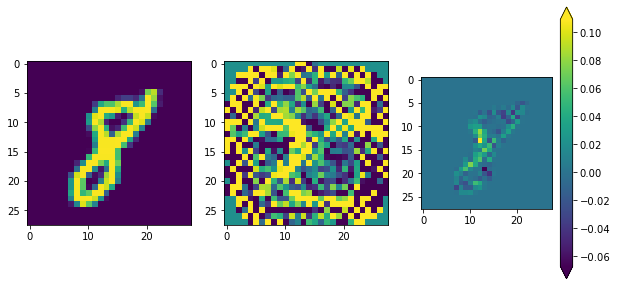

1.2580395455181397


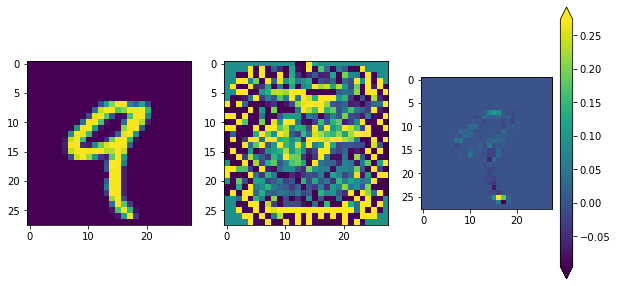

In [191]:
for t in range(0,10):
    x = oneD_bias_img(train['image'])
    y = binary_response(train['label'], t)
    betaa  = beta(x,y)
    
    print(np.dot(x[np.where(y==1)[0][0]][:784].T , betaa[:784].squeeze()))

    scale = 8
    p = (betaa[:784, 0].reshape(28,28))
    # p = StandardScaler().fit_transform(p)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5) )
    ax = axes[0]
    ax.imshow(x[np.where(y==1)[0][0]][:784].reshape(28,28))
    
    x[np.where(y==1)[0][0]][:784].reshape(28,28)
    
    ax = axes[1]
    ax.imshow(p,vmin=-0.001/scale, vmax=0.001/scale)
    
    ax = axes[2]
    aa = ax.imshow(x[np.where(y==1)[0][0]][:784].reshape(28,28) * p)
    cbar = fig.colorbar(aa, ax=ax, extend='both')
    plt.show()


In [285]:
for t in range(0,10):
    x = oneD_bias_img(train['image'])
    y = binary_response(train['label'], t)
    betaa  = beta(x,y)
    
    x_test = oneD_bias_img(test['image'])
    y_test = binary_response(test['label'], t)
    
    y_predict = []

    for i in range(len(x_test)):

        if np.dot(x_test[i].T ,betaa.squeeze()) < 0:
            y_predict.append(-1.0)
        else:
            y_predict.append(1.0)
            
    print(confusion_matrix(np.array(y_predict),y_test.squeeze()))

[[8977  114]
 [  43  866]]
[[8799  100]
 [  66 1035]]
[[8940  388]
 [  28  644]]
[[8947  355]
 [  43  655]]
[[8980  297]
 [  38  685]]
[[9052  480]
 [  56  412]]
[[8968  186]
 [  74  772]]
[[8911  293]
 [  61  735]]
[[8986  470]
 [  40  504]]
[[8920  449]
 [  71  560]]
